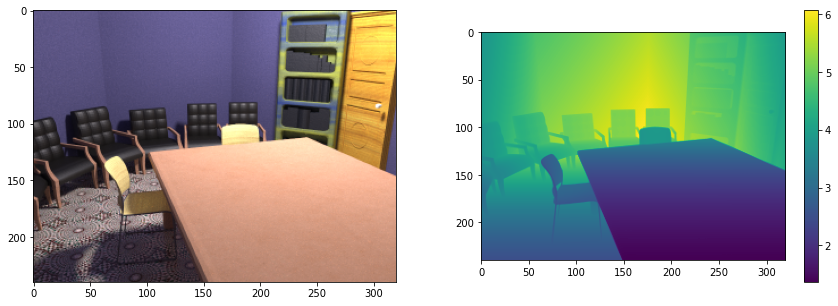

In [57]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from pathlib import Path
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')
from dataset_openroomsV4_utils import loadBinary
import matplotlib.pyplot as plt
import cv2
import torch

png_path_ROOT = Path('/data/ruizhu/OR-pngs')
RAW_ROOT = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation')

val_list_file = '/home/ruizhu/Documents/Projects/semanticInverse/train/data/openrooms/list_OR_V4full/list/val.txt'
list_read = open(val_list_file).readlines()
scene_list = []
frame_info_list = []
for line in list_read:
    line = line.strip()
    line_split = line.split(' ')
    meta_split = line_split[2].split('/')[0]
    scene_name = line_split[2].split('/')[1]
    frame_id = int(line_split[1])
    frame_info_list.append([meta_split, scene_name, frame_id])

frame_id_pick = 1
meta_split, scene_name, frame_id = frame_info_list[frame_id_pick]

im_width, im_height = 320, 240

png_path = png_path_ROOT / meta_split / scene_name / ('im_%d.png'%frame_id)
depth_path = RAW_ROOT / (meta_split.replace('DiffMat', '').replace('DiffLight', '')) / scene_name / ('imdepth_%d.dat'%frame_id)

im = plt.imread(png_path)
im = cv2.resize(im, (im_width, im_height), interpolation=cv2.INTER_AREA )

depth = loadBinary(depth_path, if_resize=True, im_width=im_width, im_height=im_height)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(depth)
plt.colorbar()
plt.show()


im_tensor = torch.from_numpy(im.transpose(2, 0, 1)).unsqueeze(0).cuda()
depth_tensor = torch.from_numpy(depth).unsqueeze(0).cuda()

# SSN 2D from RGB feats/matseg feats

In [60]:
import torch
import numpy as np

task_name = '20210719-233411--eval_matseg_resume20201120-223702'
save_file_ROOT = Path('/newfoundland2/ruizhu/semanticInverse_resources/Summary_vis_20210504/')
embedding_file_name = save_file_ROOT / task_name / ('matseg_pred_embedding_tid306000_idx%d.npy'%frame_id_pick)

embedding = np.load(embedding_file_name)
embedding_tensor = torch.from_numpy(embedding).cuda().unsqueeze(0)

from models_def.model_nvidia.AppGMM_adaptive import SSNFeatsTransformAdaptive
from skimage.segmentation import mark_boundaries

# spixel_nums=(6, 4)
spixel_nums=(12, 8)
ssn_op = SSNFeatsTransformAdaptive(None, (spixel_nums[1], spixel_nums[0]))

# ssn_output = ssn_op(im_tensor)
ssn_output = ssn_op(embedding_tensor, tensor_to_transform=im_tensor)

abs_affinity, feats_recon = ssn_output['abs_affinity'], ssn_output['feats_recon']
abs_affinity_np = abs_affinity.squeeze().detach().cpu().numpy()
feats_recon_np = feats_recon.squeeze().detach().cpu().numpy()
print(abs_affinity_np.shape, feats_recon_np.shape) # (12, 240, 320) (3, 240, 320)

im_recon = feats_recon_np.transpose(1, 2, 0)

ssn_2d iteration took : 97.240210 ms for 010 iters
(96, 240, 320) (3, 240, 320)


(96, 240, 320) (3, 240, 320)
(240, 320)


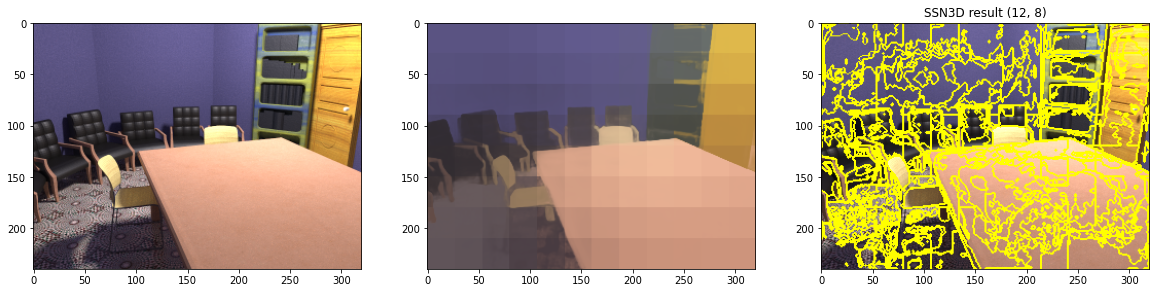

In [61]:
abs_affinity, feats_recon = ssn_output['abs_affinity'], ssn_output['feats_recon']
abs_affinity_np = abs_affinity.squeeze().detach().cpu().numpy()
feats_recon_np = feats_recon.squeeze().detach().cpu().numpy()
print(abs_affinity_np.shape, feats_recon_np.shape) # (12, 240, 320) (3, 240, 320)

affinity_matrix_label = np.argmax(abs_affinity_np, 1)

im_recon = feats_recon_np.transpose(1, 2, 0)

affinity_matrix_label = torch.argmax(abs_affinity, 1).squeeze().detach().cpu().numpy()
print(affinity_matrix_label.shape)
im_ssn_result = mark_boundaries(im, affinity_matrix_label)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(im)
plt.subplot(132)
plt.imshow(im_recon)
ax = plt.subplot(133)
plt.imshow(im_ssn_result)
ax.set_title('SSN3D result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))
plt.show()

# SSN 3D

In [52]:
import models_def.model_nvidia.AppGMM_singleFrame as AppGMM
from utils.utils_scannet import convert_IntM_from_OR, CamIntrinsic_to_cuda

spixel_nums=(16, 12)
# spixel_nums=(6, 4)

MODEL_GMM = AppGMM.AppGMM(None, spixel_nums=spixel_nums)

cam_K_320x240 = np.array([[288.9354, 0., 160.], [0., 288.9354, 120.], [0., 0.,1.]]) # for 240x320 OR ONLY
cam_intrinsic = convert_IntM_from_OR(cam_K_320x240)
CamIntrinsic_to_cuda(cam_intrinsic, device='cuda') 
MODEL_GMM.set_camintrinsic(cam_intrinsic)

input_dict_GMM = {'imgs_ref': im_tensor, 'dmaps_ref': depth_tensor}
return_dict_GMM = MODEL_GMM.forward(input_dict_GMM, batch_idx=0, return_dict=True, if_recon_depth=True)
abs_affinity = return_dict_GMM['gamma_update']

print(return_dict_GMM.keys())

im_resampled_ssn3d = MODEL_GMM.appearance_recon(return_dict_GMM['gamma_update'], input_dict_GMM['imgs_ref'], scale_feat_map=1)
im_resampled_ssn3d.shape


dict_keys(['gmm_params_update', 'gamma_update', 'dmap_update_resample', 'sigma_update_resample'])


torch.Size([1, 3, 240, 320])

(240, 320)


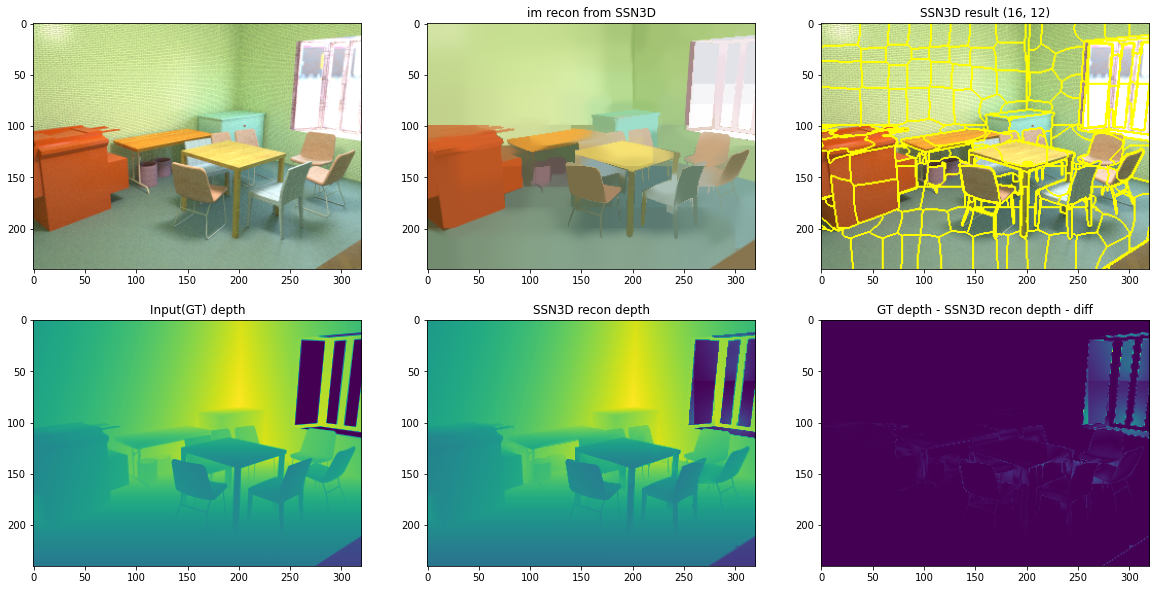

In [53]:
depth_recon = return_dict_GMM['dmap_update_resample'].squeeze().detach().cpu().numpy()
affinity_matrix_label = torch.argmax(abs_affinity, 1).squeeze().detach().cpu().numpy()
print(affinity_matrix_label.shape)
im_ssn3d_result = mark_boundaries(im, affinity_matrix_label)
im_resampled_ssn3d_np = im_resampled_ssn3d.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.imshow(im)
ax = plt.subplot(232)
plt.imshow(im_resampled_ssn3d_np)
ax.set_title('im recon from SSN3D')
ax = plt.subplot(233)
plt.imshow(im_ssn3d_result)
ax.set_title('SSN3D result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))

ax = plt.subplot(234)
plt.imshow(depth)
ax.set_title('Input(GT) depth')
ax = plt.subplot(235)
plt.imshow(depth_recon)
ax.set_title('SSN3D recon depth')
ax = plt.subplot(236)
plt.imshow(np.abs(depth_recon-depth))
ax.set_title('GT depth - SSN3D recon depth - diff')
plt.show()